In [106]:
import numpy as np
import librosa
import os
import glob
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pywt


In [107]:
# Path to your data folder, where heart sound .wav files are stored in class-wise folders
data_path = r"C:\Users\pasar\Desktop\Sem_3\msa\codes\Data"  # Change this to your actual data path

# Example: Dictionary to store extracted features for each heart condition
data = {
    'Mitral Stenosis (MS)': [],  
    'Mitral Regurgitation (MR)': [],  
    'Mitral Valve Prolapse (MVP)': [],  
    'Aortic Stenosis (AS)': [],  
    'Normal': []   
}

In [108]:
def extract_features(file_path):
    # List to store the extracted features
    features = []
    
    # Load the audio file
    y, sr = librosa.load(file_path, sr=None)
    
    # 1. Log Mel Spectrogram
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    log_mel_spect = librosa.power_to_db(mel_spect)
    features.append(np.mean(log_mel_spect, axis=1))

    # 2. MFCC
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    features.append(np.mean(mfccs, axis=1))
    
    # 3. Delta and Delta-Delta (MFCC Derivatives)
    delta_mfcc = librosa.feature.delta(mfccs)
    delta_delta_mfcc = librosa.feature.delta(mfccs, order=2)
    features.append(np.mean(delta_mfcc, axis=1))
    features.append(np.mean(delta_delta_mfcc, axis=1))
    
    # 4. Discrete Wavelet Transform (DWT)
    coeffs = pywt.wavedec(y, 'db1', level=5)
    features.append(np.hstack([np.mean(c) for c in coeffs]))

    # 5. Chroma Feature
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    features.append(np.mean(chroma, axis=1))
    
    # 6. Zero-Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    features.append(np.mean(zcr))
    
    # 7. Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    features.append(np.mean(spectral_centroid))
    
    # 8. Spectral Contrast (Dynamically adjusted)
    nyquist = sr / 2  # Nyquist frequency
    fmin = max(200.0, nyquist / 10)  # Ensure fmin is at least 200 Hz or 1/10th of the Nyquist
    n_bands = min(6, int(np.floor(np.log2(nyquist / fmin))))  # Adjust n_bands to not exceed Nyquist
    
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, fmin=fmin, n_bands=n_bands)
    features.append(np.mean(spectral_contrast, axis=1))
    
    # 9. Energy (RMS)
    rms = librosa.feature.rms(y=y)
    features.append(np.mean(rms))
    
    # 10. Temporal Flatness (Spectral Flatness)
    flatness = librosa.feature.spectral_flatness(y=y)
    features.append(np.mean(flatness))
    
    # Combine all features into a single array
    return np.hstack(features)


In [109]:
for label in data.keys():
    folder = os.path.join(data_path, label)
    features_list = []
    for file in glob.glob(folder + "/*.wav"):
        features = extract_features(file)
        if features.size > 0:
            features_list.append(features)
        else:
            print(f"No features extracted for file: {file}")
    data[label] = np.array(features_list)  # Convert to NumPy array

print("Feature extraction completed.")

c:\Users\pasar\anaconda3\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Feature extraction completed.


In [110]:
# Combine all data into one dataset (X) and create labels (y)
X = np.vstack([data['Aortic Stenosis (AS)'], 
               data['Mitral Stenosis (MS)'], 
               data['Mitral Regurgitation (MR)'], 
               data['Mitral Valve Prolapse (MVP)'], 
               data['Normal']])

y = np.concatenate([[0]*len(data['Aortic Stenosis (AS)']),
                    [1]*len(data['Mitral Stenosis (MS)']),
                    [2]*len(data['Mitral Regurgitation (MR)']),
                    [3]*len(data['Mitral Valve Prolapse (MVP)']),
                    [4]*len(data['Normal'])])

print(f"Shape of X (feature matrix): {X.shape}")
print(f"Shape of y (labels): {y.shape}")



Shape of X (feature matrix): (1000, 193)
Shape of y (labels): (1000,)


In [111]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [112]:
from sklearn.model_selection import train_test_split


In [113]:


# Assuming you have X_data (features) and y_labels (labels)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)


In [114]:
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1, 1)
X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], 1, 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1, 1)

print("X_train_reshaped shape:", X_train_reshaped.shape)
print("y_train shape:", y_train.shape)

X_train_reshaped shape: (600, 193, 1, 1)
y_train shape: (600,)


In [138]:
import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras import layers, models, Input

In [139]:
def create_cnn_lstm_attention_model(input_shape, num_classes=5):
    inputs = Input(shape=input_shape)
    
    # CNN Layers
    x = layers.Conv2D(64, (3, 1), activation='relu', padding='same')(inputs)
    x = layers.Conv2D(64, (3, 1), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Conv2D(128, (3, 1), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 1), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Conv2D(256, (3, 1), activation='relu', padding='same')(x)
    x = layers.Conv2D(256, (3, 1), activation='relu', padding='same')(x)
    x = layers.Conv2D(256, (3, 1), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)
    x = layers.Dropout(0.5)(x)
    
    # Reshape for LSTM
    shape = x.shape
    time_steps = shape[1]
    features = shape[2] * shape[3]
    x = layers.Reshape((time_steps, features))(x)
    
    # LSTM Layer
    x = layers.LSTM(128, return_sequences=True, dropout=0.5)(x)
    

    # Fully Connected Layers
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    return model

In [140]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras_tuner import HyperModel, RandomSearch


In [144]:
input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2], X_train_reshaped.shape[3])
model = create_cnn_lstm_attention_model(input_shape)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)


In [142]:
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 193, 1, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 193, 1, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 193, 1, 64)     │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 96, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 96, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 96, 1, 128)     │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 96, 1, 128)     │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 48, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 48, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 48, 1, 256)     │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 48, 1, 256)     │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 48, 1, 256)     │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 24, 1, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 24, 1, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_8 (Reshape)             │ (None, 24, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 24, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 24, 128)        │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 24, 5)          │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 793,157 (3.03 MB)

 Trainable params: 793,157 (3.03 MB)

 Non-trainable params: 0 (0.00 B)

In [143]:
history = model.fit(X_train_reshaped, y_train, 
                    validation_data=(X_val_reshaped, y_val),
                    epochs=50, 
                    batch_size=32, 
                    callbacks=[early_stopping, reduce_lr])

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 667
'y' sizes: 600


In [122]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

n_splits = 3  # You can keep it 5 or any number based on your dataset
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_accuracies = []
fold_losses = []

for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"Training fold {fold + 1}/{n_splits}...")
    
    # Split data
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]
    
    # Standardize fold data
    scaler = StandardScaler()
    X_train_fold_scaled = scaler.fit_transform(X_train_fold)
    X_val_fold_scaled = scaler.transform(X_val_fold)
    
    # Reshape data for the CNN + LSTM model
    X_train_reshaped = X_train_fold_scaled.reshape(X_train_fold_scaled.shape[0], X_train_fold_scaled.shape[1], 1, 1)
    X_val_reshaped = X_val_fold_scaled.reshape(X_val_fold_scaled.shape[0], X_val_fold_scaled.shape[1], 1, 1)
    
    # Define input shape for the model
    input_shape = (X_train_reshaped.shape[1], 1, 1)
    
    # Create a fresh model for each fold
    model = create_cnn_lstm_attention_model(input_shape, num_classes=5)
    
    # Define callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    
    # Train the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(
        X_train_reshaped, y_train_fold, 
        epochs=50, 
        batch_size=32, 
        validation_data=(X_val_reshaped, y_val_fold),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(X_val_reshaped, y_val_fold, verbose=0)
    fold_losses.append(val_loss)
    fold_accuracies.append(val_accuracy)
    print(f"Fold {fold + 1}: Loss = {val_loss}, Accuracy = {val_accuracy}")

# Average results over all folds
print(f"Average Validation Accuracy: {np.mean(fold_accuracies)}")
print(f"Average Validation Loss: {np.mean(fold_losses)}")


Training fold 1/3...
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.1925 - loss: 1.6101 - val_accuracy: 0.1737 - val_loss: 1.6003 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.2593 - loss: 1.5995 - val_accuracy: 0.1976 - val_loss: 1.5893 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.2549 - loss: 1.5826 - val_accuracy: 0.3263 - val_loss: 1.5520 - learning_rate: 0.0010
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.2924 - loss: 1.5760 - val_accuracy: 0.3533 - val_loss: 1.5097 - learning_rate: 0.0010
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.3589 - loss: 1.4870 - val_accuracy: 0.3144 - val_loss: 2.2561 - learning_rate: 0.0010
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.3511 - loss: 1.4397 - val_accuracy: 0.3683 - val_loss: 1.3960 - learning_rate: 0.0010
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.3906 - l

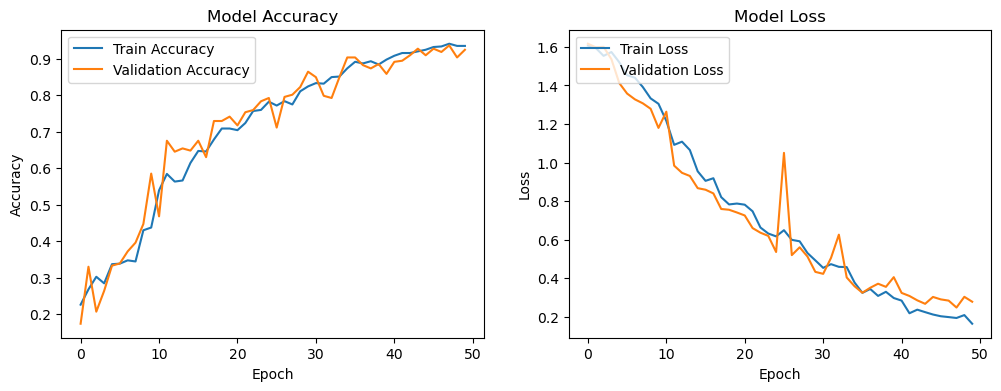

In [127]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()


In [131]:
vala_loss, vala_acc = model.evaluate(X_val_reshaped, y_val_fold, verbose=0)
print(f"Validation Accuracy: {vala_acc}, Validation Loss: {vala_loss}")

Validation Accuracy: 0.9369369149208069, Validation Loss: 0.24857120215892792


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


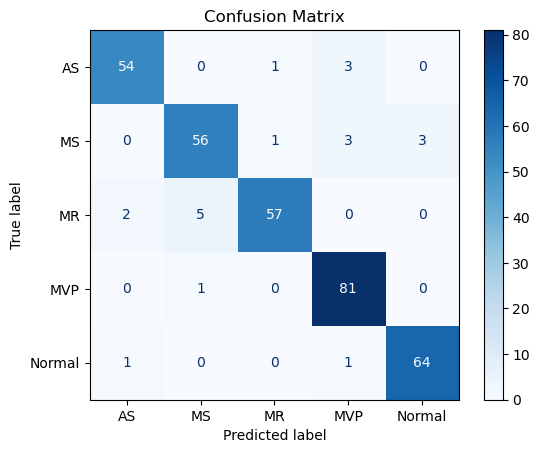

In [132]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = model.predict(X_val_reshaped)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_val_fold, y_pred)
cr = classification_report(y_val_fold, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['AS', 'MS', 'MR', 'MVP', 'Normal'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [128]:
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9770 - loss: 0.1043
Test Loss: 0.10055092722177505, Test Accuracy: 0.9750000238418579


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


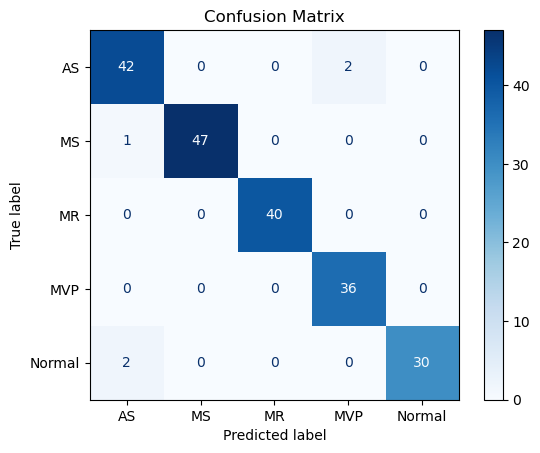

In [133]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = np.argmax(model.predict(X_test_reshaped), axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['AS', 'MS', 'MR', 'MVP', 'Normal'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [134]:
model.save('best_hybrid_model.h5')  # Save model



In [137]:
model = tf.keras.models.load_model('best_hybrid_model.h5')  # Load model

file_path = r"C:\Users\pasar\Desktop\Sem_3\msa\Heartbeat\normal__103_1305031931979_B.wav"  # Change this to your actual file path

ValueError: Unknown layer: 'AttentionLayer'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.